In [6]:
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import numpy as np
import pandas as pd
import image_utils as iu
import tensorflow as tf
import os
from PIL import Image, ImageEnhance
from PIL import ImageFilter
from keras.models import load_model
from shutil import copy2
import matplotlib.pyplot as plt
import geotiff_utils as gu
from IPython.display import display, HTML
# from ipycanvas import Canvas
from ipywidgets import Image as ipyImage
from pyproj import Proj, transform
import uuid
import shutil
import numpy_utils as nu
import object_detection_utils as odu


In [7]:
data_path = 'data'
object_detection_path = os.path.join(data_path, 'object-detection')
original_path = os.path.join(object_detection_path, 'original')
real_data_path = os.path.join(original_path, 'real')
mask_data_path = os.path.join(original_path, 'mask')
# divided images
divided_data_path = os.path.join(object_detection_path, 'divided')
#Labeled data
object_detection_labeled_data_path = os.path.join(
    object_detection_path, 'object-detection-labeled')
object_detection_labeled_image_data_path = os.path.join(
    object_detection_labeled_data_path, 'images')
object_detection_labeled_annotation_data_path = os.path.join(
    object_detection_labeled_data_path, 'annotations')
#
object_detection_aug_data_path = os.path.join(
    object_detection_path, 'object-detection-labeled-aug')
object_detection_labeled_aug_image_data_path = os.path.join(
    object_detection_aug_data_path, 'images')
object_detection_labeled_aug_annotation_data_path = os.path.join(
    object_detection_aug_data_path, 'annotations')
#
SETUP_PATH = 'Tensorflow'
WORKSPACE_PATH = os.path.join(SETUP_PATH, 'workspace')
IMAGE_PATH = os.path.join(WORKSPACE_PATH, 'images')
train_path = os.path.join(IMAGE_PATH, 'train')
test_path = os.path.join(IMAGE_PATH, 'test')

#Create dirs
iu.create_dir_if_not_exists(data_path)
iu.create_dir_if_not_exists(object_detection_path)


In [5]:
#open the land use land cover map.
geoTiff = gdal.Open(
    os.path.join(data_path, 'Orthomosaic.rgb.tif'), gdal.GA_ReadOnly)
geoTiff.RasterCount, geoTiff.RasterXSize, geoTiff.RasterYSize, geoTiff.GetMetadata()
xmin_i, xres_i, xskew_i, ymin_i, yskew_r, yres_i = geoTiff.GetGeoTransform()
print('Metadata')
print('No of bands:', geoTiff.RasterCount)
print('Image Resolution:', geoTiff.RasterXSize, 'x',  geoTiff.RasterYSize)
# print('Projection:', geoTiff.GetProjection())
print('Latitude:', xmin_i)
print('Longitude:', ymin_i)
print('Rotation:', xskew_i)
print('Pixel Resolution:', xres_i, 'meters', 'x', yres_i, 'meters')
print('Projection:', geoTiff.GetProjection())


Metadata
No of bands: 4
Image Resolution: 145462 x 85471
Latitude: 513352.8660336281
Longitude: 676296.814961423
Rotation: 0.0
Pixel Resolution: 0.017562390670727446 meters x -0.017562390670727446 meters
Projection: PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


In [6]:
l = gu.get_l_band(geoTiff, 4)

In [4]:
85471 / 512


166.935546875

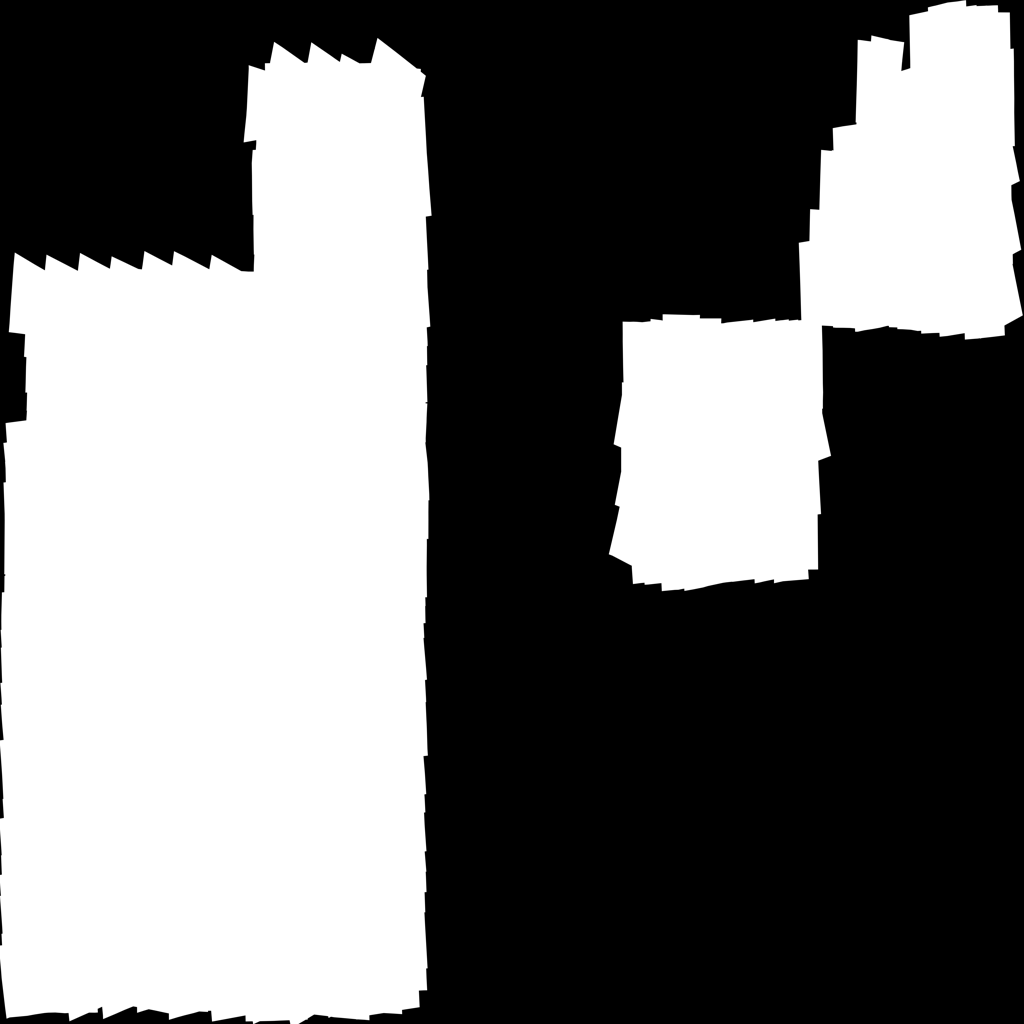

In [8]:
Image.fromarray(l.reshape((l.shape[0], l.shape[1]))).resize((1024, 1024))

In [ ]:
#Visualize image
im = Image.fromarray(np.array(np_n_im.reshape(
    np_n_im.shape[0], np_n_im.shape[1]), dtype=np.uint8))
im


In [11]:
geoTiff.RasterYSize / 1024


83.4677734375

In [4]:
iu.create_dir_if_not_exists(divided_data_path)
# row_count = 222
# col_count = 154
row_count = int(geoTiff.RasterYSize / 512)
col_count = int(geoTiff.RasterXSize / 512)
width, height = geoTiff.RasterXSize, geoTiff.RasterYSize
left = 0
top = 0
right = width / col_count
bottom = height / row_count
part_count = col_count * row_count
i = 0
for r in range(row_count):
    top = int(r * (height / row_count))
    bottom = int(top + (height / row_count))
    for c in range(col_count):
        # part_filename = str(uuid.uuid4())
        part_filename = str(i)
        left = int(c * (width / col_count))
        right = int(left + (width / col_count))
        np_part = gu.crop_geoTiff(
            geoTiff, left, top, right, bottom, dtype='uint8')
        # print(np_part.shape)
        rgb_np_part = np_part[:, :, 0:3]
        # print(rgb_np_part.shape)
        image_part = Image.fromarray(rgb_np_part)
        image_part.save(os.path.join(
            divided_data_path, part_filename + '.png'))
        i += 1
        iu.print_progress(i, part_count)


Progress: [##################################################] 100.0%

In [5]:
#Images that do not contain any information is deleted from storage.
divided_images_path = iu.get_all_files(divided_data_path)

In [6]:
len(divided_images_path)


47143

In [7]:
del_count = 0
i = 0
for image_path in divided_images_path:
    real_image = iu.read_image(os.path.join(divided_data_path, image_path))
    np_real_image = np.asarray(real_image)
    if np_real_image.max() == 0:
        os.remove(os.path.join(divided_data_path, image_path))
        del_count += 1
    i += 1
    iu.print_progress(i, len(divided_images_path))
print(' ',del_count, 'files deleted')


Progress: [##################################################] 100.0%  25661 files deleted


## Prepare Labeled Data

In [10]:
# stores the path of an image and a mask pair
class DataLabelPair:
    def __init__(self, data_real_path, label_path):
        self.data_real_path = data_real_path
        self.label_path = label_path

In [8]:
labeled_images_path = iu.get_all_files(
    object_detection_labeled_annotation_data_path, '*.xml')

In [11]:
# Gets the file path of real images and its mask pair.
plantain_data = []
for path in labeled_images_path:
    plantain_image = DataLabelPair(os.path.join(
        object_detection_labeled_image_data_path, path.replace('.xml', '.png')), os.path.join(object_detection_labeled_annotation_data_path, path))
    plantain_data.append(plantain_image)

In [12]:
def plot_rect(image, rects, box_color, thickness=1):
    np_image = np.asarray(image)
    np_image = np.copy(np_image)
    # print(np_image)
    for rect in rects:
        x, y, w, h = rect
        r, g, b = box_color
        # get the row to mark.
        # draws top line
        np_image[y: y + thickness, x:x + w] = [r, g, b]
        # draws left line
        np_image[y: y + h, x: x + thickness] = [r, g, b]
        # draws right line
        np_image[y: y + h + thickness, x + w: x + w + thickness] = [r, g, b]
        # draws bottom line
        np_image[y + h: y + h + thickness, x:x + w] = [r, g, b]
    return Image.fromarray(np_image)


In [22]:
len(plantain_data)

201

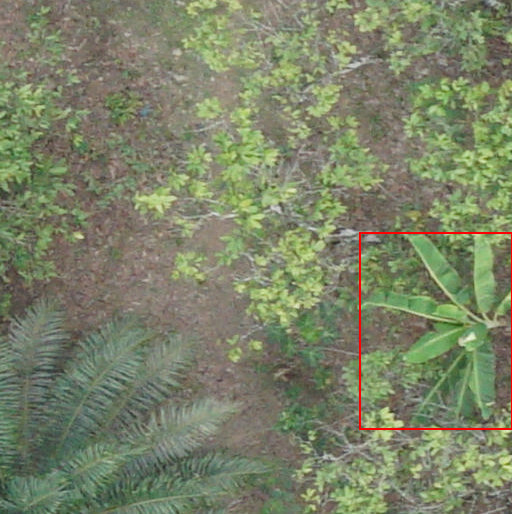

In [21]:
import random
indx = random.randint(0, len(plantain_data)- 1)
im = iu.read_image(plantain_data[indx].data_real_path, 'RGB')
bboxesInfo = odu.read_xml(plantain_data[indx].label_path)[3]
rects = []
for bboxInfo in bboxesInfo:
    rects.append(odu.get_rect(bboxInfo[1]))
plot_rect(im, rects, (255, 0, 0), 2)


Augment Data

In [45]:
odu.read_xml('data/object-detection/object-detection-labeled/Annotations/1c00b57d-9901.xml')

('images',
 '1c00b57d-9901.jpg',
 (512, 514, 3),
 [('Plantain', (256, 106, 438, 335)),
  ('Plantain', (48, 431, 202, 513)),
  ('Plantain', (27, 159, 76, 268)),
  ('Plantain', (127, 290, 195, 378)),
  ('Plantain', (0, 17, 95, 127)),
  ('Plantain', (194, 425, 388, 513)),
  ('Plantain', (396, 416, 508, 513)),
  ('Plantain', (197, 5, 398, 108)),
  ('Plantain', (409, 0, 448, 117)),
  ('Plantain', (444, 61, 510, 219)),
  ('Plantain', (142, 135, 187, 227)),
  ('Plantain', (175, 160, 240, 236))])

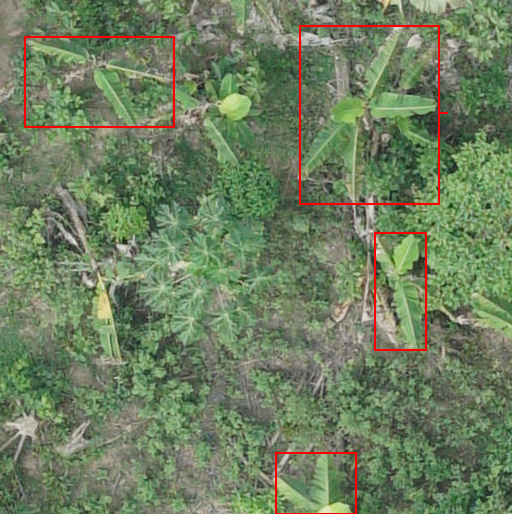

In [41]:
fl_im, fl_bboxes_info = odu.flip_labeled_image_left_right(im, bboxesInfo)
fl_rects = []
for bboxInfo in fl_bboxes_info:
    fl_rects.append(odu.get_rect(bboxInfo[1]))
plot_rect(fl_im, fl_rects, (255, 0, 0), 2)

In [42]:
im.size

(512, 514)

In [24]:
def get_bbox_info_from_xml(path):
    bboxesInfo = odu.read_xml(path)[3]
    rects = []
    for bboxInfo in bboxesInfo:
        rects.append(odu.get_rect(bboxInfo[1]))
    return rects


def aug_data(data_pair: DataLabelPair):
    images_augmented = []
    image = iu.read_image(data_pair.data_real_path)
    image = image.resize((512, 512))
    bboxes_info = odu.read_xml(data_pair.label_path)[3]
    images_augmented.append((image, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 90, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 180, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 270, bboxes_info))
    image, bboxes_info = odu.flip_labeled_image_left_right(image, bboxes_info)
    images_augmented.append((image, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 90, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 180, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 270, bboxes_info))
    return images_augmented

In [25]:
# images are augmented and saved on disk.
iu.create_dir_if_not_exists(object_detection_aug_data_path)
iu.create_dir_if_not_exists(object_detection_labeled_aug_image_data_path)
iu.create_dir_if_not_exists(object_detection_labeled_aug_annotation_data_path)
for data in plantain_data:
    # real_image = iu.read_image(data.data_real_path, 'RGB')
    annotation = odu.read_xml(data.label_path)
    folder, filename, image_dimen, bbox_info = annotation
    image_dimen = (512, 512, 3)
    # bboxes_info = annotation[3]
    data_aug = aug_data(data)
    for x in range(len(data_aug)):
        part_filename = str(uuid.uuid4())
        real_image = data_aug[x][0]
        bboxes_info = data_aug[x][1]
        #
        real_image.save(os.path.join(
            object_detection_labeled_aug_image_data_path, part_filename + '.png'))
        odu.write_xml(os.path.join(
            object_detection_labeled_aug_annotation_data_path, part_filename + '.xml'),
            folder, part_filename + '.png', '/images', image_dimen, bboxes_info)


In [26]:
labeled_aug_images_path = iu.get_all_files(
    object_detection_labeled_aug_annotation_data_path, '*.xml')

In [27]:
# Gets the file path of real images and its mask pair.
plantain_aug_data = []
for path in labeled_aug_images_path:
    plantain_image = DataLabelPair(os.path.join(
        object_detection_labeled_aug_image_data_path, path.replace('.xml', '.png')), os.path.join(object_detection_labeled_aug_annotation_data_path, path))
    plantain_aug_data.append(plantain_image)

In [28]:
odu.read_xml(plantain_aug_data[indx].label_path)[3]


[('Plantain', (334, 126, 511, 289)), ('Plantain', (148, 9, 281, 85))]

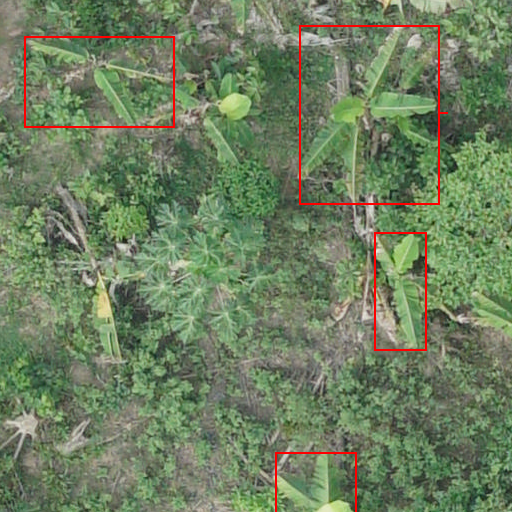

In [38]:
import random
indx = random.randint(0, len(plantain_aug_data) - 1)
im = iu.read_image(plantain_aug_data[indx].data_real_path)
bboxesInfo = odu.read_xml(plantain_aug_data[indx].label_path)[3]
rects = []
for bboxInfo in bboxesInfo:
    rects.append(odu.get_rect(bboxInfo[1]))
plot_rect(im, rects, (255, 0, 0), 2)


In [39]:
# Splits dataset into training, validation and test sets.
def train_val_test_split(val_per, test_per, input_data, labels=None):
    if labels is not None and len(input_data) != len(labels):
        raise Exception("input data and label length mismatch")
    data_len = len(input_data)
    val_len = int(data_len * (val_per / 100))
    test_len = int(data_len * (test_per / 100))
    x_val = input_data[0: val_len]
    x_test = input_data[val_len: val_len + test_len]
    x_train = input_data[val_len + test_len: data_len]
    if labels is not None:
        y_val = labels[0: val_len]
        y_test = labels[val_len: val_len + test_len]
        y_train = labels[val_len + test_len: data_len]
        return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    else:
        return x_train, x_val, x_test


In [40]:
train_images, val_images, test_images = train_val_test_split(
    10, 0, plantain_aug_data)
print('Train length:', len(train_images))
print('Val length:', len(val_images))
print('Test length', len(test_images))

Train length: 1448
Val length: 160
Test length 0


In [79]:
iu.create_dir_if_not_exists(train_path)
iu.create_dir_if_not_exists(test_path)

In [80]:
# copy training images to training folder
for train_data in train_images:
    copy2(train_data.data_real_path, os.path.join(
        train_path, os.path.basename(train_data.data_real_path)))
    copy2(train_data.label_path, os.path.join(
        train_path, os.path.basename(train_data.label_path)))

In [81]:
# copy training images to training folder
for val_data in val_images:
    copy2(val_data.data_real_path, os.path.join(
        test_path, os.path.basename(val_data.data_real_path)))
    copy2(val_data.label_path, os.path.join(
        test_path, os.path.basename(val_data.label_path)))